# Image Features Exercise

A basic exercise to show that preprocessing features aids in classification accuracy.

## Data

Using the CIFAR-10 training data.  Expected location should be in `res/cifar-10-python/cifar-10-batches-py`.

### Load CIFAR-10 Data

In [1]:
import gbl
import os
import matplotlib.pyplot as plt
import numpy as np
X, Y = gbl.load_cifar10('res/cifar-10-python/cifar-10-batches-py')

### Plot a preview of the first 100 training data

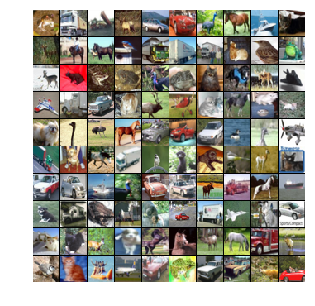

In [2]:
plt.figure(figsize=(5, 5))
gbl.plot_image(gbl.get_tile_image(X[:100], 10, 10))

## Softmax

Define the functions to train softmax regression

In [3]:
def softmax(X, w, b):
    '''Computes the softmax function.  The argmax value is the class predicted.
    
    Params:
        X (np.array): 2D array of features, i.e. can compute more than one item
        w (np.array): 2D array of weights, should be n_features by n_classes
        b (np.array): 1D array of biases, should be of size n_classes
        
    Returns:
        (np.array): 2D array of predictions, where argmax gives the class
    '''
    result = np.exp(np.dot(X, w) + b)
    result /= result.sum(-1, keepdims=True)
    return result

# The gradient step
def gradient(X, Y, w, b, alpha = 0.01):
    '''Applies a single gradient step to w and b.  Returns the updated cost.
    
    Params:
        X (np.array): A batch
        Y (np.array): 2D array of one-hot training labels
        w (np.array): 2D array of weights
        b (np.array): 1D array of biases
        alpha (float): Learning rate
        l (float): Decay parameter
        
    Returns:
        (float): The cost at the given time step.
    '''
    inv_m = 1. / len(X)
    a = softmax(X, w, b)
    d_ = a - Y
    djdw = np.dot(X.T, d_)
    djdb = d_.sum(0)
    
    w -= alpha * inv_m * djdw
    b -= alpha * inv_m * djdb
    
    return -np.sum(np.log(a) * Y) * inv_m

def compute_accuracy(X, Y, w, b):
    a = softmax(X, w, b)
    return (a.argmax(-1) == Y).sum() / len(Y)

## Training

### Softmax without feature processing

Train using softmax regression without feature processing.  This will be used to compare against the accuracy of training when preprocessing is applied.  This might take a while.

In [4]:
# Flatten the training data and normalize linearly
X_flat = X.reshape(X.shape[0], X.shape[1] * X.shape[2] * X.shape[3]) / X.max()
X_train = X_flat[:49000]
Y_train = np.eye(10, dtype=np.float32)[Y[:49000]]
X_test = X_flat[49000:]
Y_test = Y[49000:]

# Define weights, 10 classes, 32 * 32 * 3 weights per class.
w = np.random.normal(0, 1e-6, (X_train.shape[-1], 10))
b = np.random.normal(0, 1e-6, 10)

# We use this to index our batches.  When we reach the end, we randomize, meaning we reached an epoch.
rng = np.arange(len(Y_train))
start, end = 0, 100

accuracy_progress = []
cost_progress = []

for i in range(10000):
    indices = rng[start:end]
    
    cost = gradient(X_train[indices], Y_train[indices], w, b)
    if i > 0 and i % 10 == 0:
        accuracy = compute_accuracy(X_train, Y_train.argmax(-1), w, b)
        accuracy_progress.append(accuracy)
        cost_progress.append(cost)
        if i % 200 == 0:
            print("Iterations: ", i, "Accuracy: ", accuracy * 100, "Cost: ", cost)
    
    start, end = start + 100, end + 100
    if start >= len(Y_train):
        start, end = 0, 100
        np.random.shuffle(rng)

Iterations:  200 Accuracy:  31.812244898 Cost:  1.92305709942
Iterations:  400 Accuracy:  34.6816326531 Cost:  1.76698084859
Iterations:  600 Accuracy:  35.4571428571 Cost:  1.92942040547
Iterations:  800 Accuracy:  34.9591836735 Cost:  1.82487012076
Iterations:  1000 Accuracy:  36.1387755102 Cost:  1.90987343699
Iterations:  1200 Accuracy:  37.0551020408 Cost:  1.81007034562
Iterations:  1400 Accuracy:  37.8428571429 Cost:  1.82910487168
Iterations:  1600 Accuracy:  37.0959183673 Cost:  1.85616308854
Iterations:  1800 Accuracy:  37.5897959184 Cost:  1.86317092237
Iterations:  2000 Accuracy:  38.3306122449 Cost:  1.87488351614
Iterations:  2200 Accuracy:  38.4020408163 Cost:  1.93375967125
Iterations:  2400 Accuracy:  38.4510204082 Cost:  1.73816717351
Iterations:  2600 Accuracy:  38.2836734694 Cost:  1.8010565374
Iterations:  2800 Accuracy:  39.1020408163 Cost:  1.79454288952
Iterations:  3000 Accuracy:  39.7693877551 Cost:  1.55482515923
Iterations:  3200 Accuracy:  39.8142857143 Cos

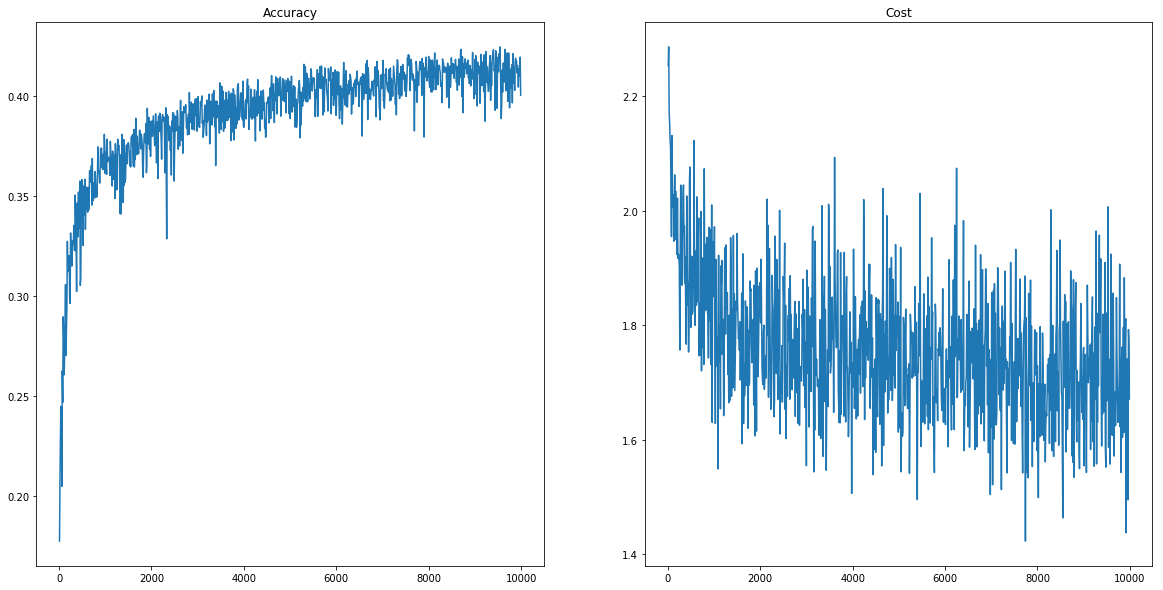

In [26]:
plt.figure(figsize=(20,10))

steps = range(10, 10000, 10)

plt.subplot(1, 2, 1)
plt.plot(steps, accuracy_progress)
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(steps, cost_progress)
plt.title('Cost')

plt.show()

The accuracy is as expected for this model.

In [28]:
print("Final training accuracy:", compute_accuracy(X_train, Y_train.argmax(-1), w, b) * 100.)
print("Validation accuracy:", compute_accuracy(X_test, Y_test, w, b) * 100.)

Final training accuracy: 41.0489795918
Validation accuracy: 41.3


### Training using HOG and HSV

We now train the model using in HSV space augmented with a HOG (Histogram of oriented gradients). There should be an improvement in accuracy.